Этот датасет представляет собой классический набор данных для задачи прогнозирования оттока клиентов (Churn Prediction) в банковской сфере. Он содержит информацию о клиентах банка, их демографические данные, финансовое состояние и историю взаимодействия с банком.

### Идентификаторы и личные данные

+ **CustomerId**: Уникальный идентификатор клиента.

+ **Surname**: Фамилия клиента.

### Демографические данные
+ **Geography**: Страна проживания клиента. В этом конкретном датасете обычно представлены три страны: Франция, Германия и Испания.
+ **Gender**: Пол клиента (Male/Female).
+ **Age**: Возраст клиента.

### Банковские и финансовые данные
+ **CreditScore**: Кредитный рейтинг клиента. Числовой показатель, отражающий кредитоспособность.
+ **Tenure**: Срок обслуживания (в годах). Показывает, сколько лет человек является клиентом этого банка.
+ **Balance**: Баланс на счете. Сумма денег, доступная клиенту. 
+ **NumOfProducts**: Количество продуктов банка, которые использует клиент (например, сберегательный счет + кредитная карта = 2).
+ **HasCrCard**: Наличие кредитной карты. Бинарный признак (1 — есть, 0 — нет).
+ **IsActiveMember**: Активность клиента. Бинарный признак (1 — активный, 0 — нет).
+ **EstimatedSalary**: Оценочная заработная плата клиента. Банк часто не знает точную зарплату и использует оценочные данные.

#### Целевая переменная (Target)
**Exited**: Факт оттока. Это то, что нужно предсказать.
+ 1: Клиент ушел (закрыл счет/перестал пользоваться услугами).
+ 0: Клиент остался.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/bank-churn/train.csv
/kaggle/input/bank-churn/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/bank-churn/train.csv')

# Exploring data and gain insights

In [3]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
df.shape

(165034, 14)

Посмотрим, какие значения и какие типы в каждой колонке

In [5]:
from tabulate import tabulate

def print_col_info(df):
    uniq_col_count = []
    for col in df:
        uniq_count = df[col].unique()
        types = set([type(x) for x in uniq_count])
        uniq_col_count.append([col, len(uniq_count), uniq_count[:10], types])

    uniq_col_count.sort(key=lambda x: x[1])

    print(tabulate(uniq_col_count, headers=['Col', 'Uniq_num', 'Values (top 10)', 'Types']))
    
print_col_info(df)

Col                Uniq_num  Values (top 10)                                                           Types
---------------  ----------  ------------------------------------------------------------------------  -------------------------
Gender                    2  ['Male' 'Female']                                                         {<class 'str'>}
HasCrCard                 2  [1. 0.]                                                                   {<class 'numpy.float64'>}
IsActiveMember            2  [0. 1.]                                                                   {<class 'numpy.float64'>}
Exited                    2  [0 1]                                                                     {<class 'numpy.int64'>}
Geography                 3  ['France' 'Spain' 'Germany']                                              {<class 'str'>}
NumOfProducts             4  [2 1 3 4]                                                                 {<class 'numpy.int64'>}
Tenure      

In [6]:
df.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
# проверим на наличие дубликатов строк

df.duplicated().sum()

0

In [8]:
df.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
id,165034.000000,82516.500000,47641.356500,0.000000,41258.250000,82516.500000,123774.750000,165033.000000
CustomerId,165034.000000,15692005.019026,71397.816791,15565701.000000,15633141.000000,15690169.000000,15756824.000000,15815690.000000
CreditScore,165034.000000,656.454373,80.103340,350.000000,597.000000,659.000000,710.000000,850.000000
Age,165034.000000,38.125888,8.867205,18.000000,32.000000,37.000000,42.000000,92.000000
Tenure,165034.000000,5.020353,2.806159,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,165034.000000,55478.086689,62817.663278,0.000000,0.000000,0.000000,119939.517500,250898.090000
NumOfProducts,165034.000000,1.554455,0.547154,1.000000,1.000000,2.000000,2.000000,4.000000
HasCrCard,165034.000000,0.753954,0.430707,0.000000,1.000000,1.000000,1.000000,1.000000
IsActiveMember,165034.000000,0.497770,0.499997,0.000000,0.000000,0.000000,1.000000,1.000000
EstimatedSalary,165034.000000,112574.822734,50292.865585,11.580000,74637.570000,117948.000000,155152.467500,199992.480000


1. Целевая переменная (Exited - Отток)
Дисбаланс классов: Среднее значение (mean) составляет 0.211 (примерно 21%).

2. Финансовые аномалии (Balance)
Половина клиентов с нулевым балансом: Медиана (50%) и даже 25-й перцентиль равны 0.00. Это значит, что как минимум у половины клиентов на счете 0 денег. Это очень важный инсайт: вероятно, многие используют банк только для кредитной карты или транзитного обслуживания, не храня средства.

Большой разброс: При этом стандартное отклонение (std ≈ 62 817) очень велико, а максимум достигает 250 898.

3. Портрет клиента
Возраст (Age): Аудитория достаточно молодая. Средний возраст — 38 лет, медианный — 37. 75% клиентов моложе 42 лет. Однако есть и пожилые клиенты (до 92 лет).

Кредитный рейтинг (CreditScore): Средний рейтинг около 656, что является нормальным/средним показателем. Разброс от 350 до 850 (полный диапазон скоринга).

Активность (IsActiveMember): Примерно 50% клиентов (среднее 0.497) являются активными пользователями банка.

Кредитные карты (HasCrCard): У 75% клиентов (среднее 0.75) есть кредитная карта.

In [9]:
df.groupby("Exited").agg({"Age": "mean"})

,Age
Exited,
0,36.560480
1,43.958478


 Риск оттока значительно возрастает с возрастом. Клиенты в возрасте 40–50 лет находятся в "зоне риска", тогда как более молодые клиенты (до 35–38 лет) более стабильны.

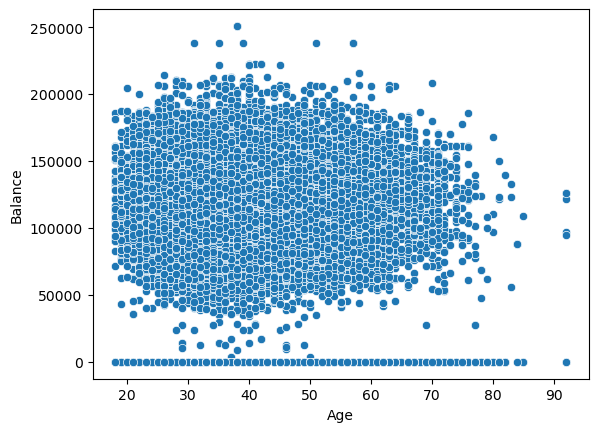

In [10]:
import seaborn as sns
fig = sns.scatterplot(df, x='Age', y='Balance')
plt.show()

**Четкая линия на уровне 0**: Внизу графика видна плотная горизонтальная полоса. Это подтверждает, что огромная часть клиентов (независимо от возраста) имеет нулевой баланс. Вероятно, они используют банк только для транзакций или кредитных продуктов, не храня сбережения.

**Отсутствие линейной связи**: Среди клиентов с деньгами (баланс > 0) не наблюдается четкой зависимости "чем старше, тем богаче". Облако точек распределено равномерно в диапазоне от 30 до 50 лет, с балансами от 50к до 150к+

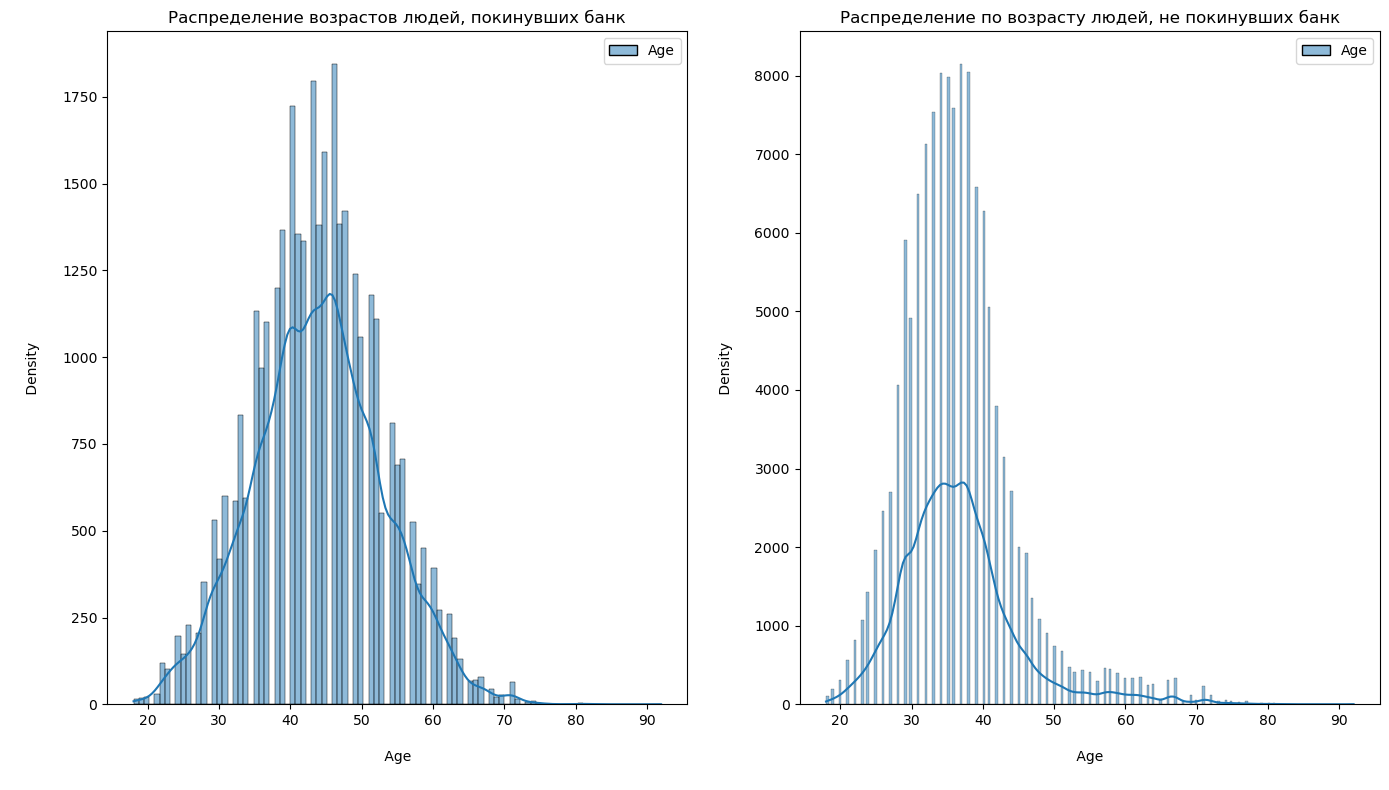

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
sns.histplot(df.loc[df.Exited == 1][["Age"]],kde=True,color="grey", ax=axes[0])
axes[0].set_title('Распределение возрастов людей, покинувших банк')
axes[0].set_xlabel('\n Age \n')
axes[0].set_ylabel('\n Density \n')

sns.histplot(df.loc[df.Exited == 0][["Age"]],kde=True,color="grey", ax=axes[1])
axes[1].set_title('Распределение по возрасту людей, не покинувших банк')
axes[1].set_xlabel('\n Age \n')
axes[1].set_ylabel('\n Density \n')
plt.tight_layout()
plt.show()

In [12]:
#  Посмотрим статистику по сроку владения

df.groupby("Tenure").agg({"Balance": "mean"})

,Balance
Tenure,
0,61772.331067
1,57901.156943
2,53651.684208
3,56470.567355
4,54324.882710
5,55805.037831
6,55327.924977
7,53036.842830
8,54895.059781


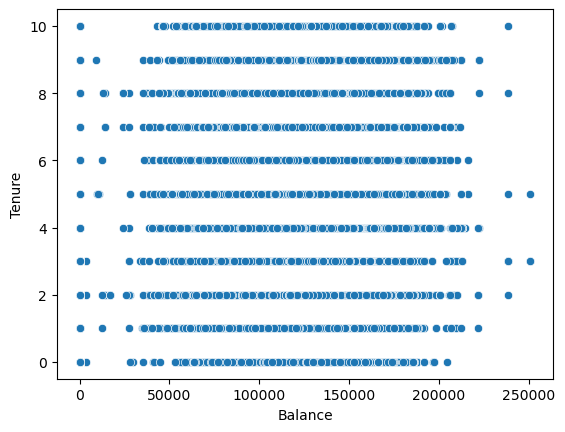

In [13]:
fig = sns.scatterplot(df, x='Balance', y='Tenure')
plt.show()

Баланс не зависит от стажа: Средний баланс для всех групп Tenure (от 0 до 10 лет) колеблется в узком диапазоне 53k - 161k. Нет тренда накопления средств со временем.

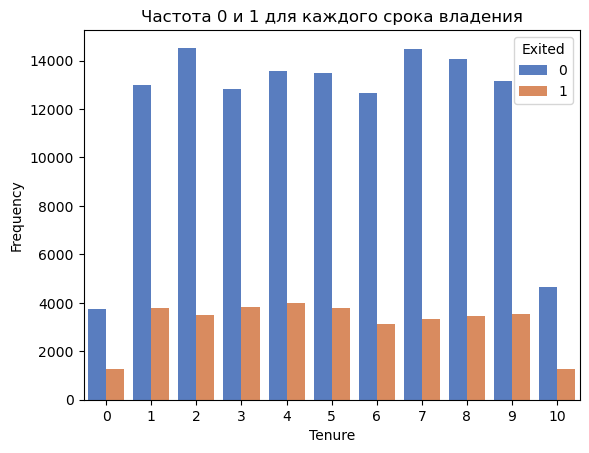

In [14]:
counts = df.groupby(['Tenure', 'Exited']).size().reset_index(name='Frequency')
sns.barplot(x='Tenure', y='Frequency', hue='Exited', data=counts, palette='muted')
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.title('Частота 0 и 1 для каждого срока владения')
plt.show()

Процент оттока (рыжие столбцы по сравнению с синими) визуально остается примерно одинаковым для всех сроков владения от 1 до 9 лет. Нет такого, что "новички уходят чаще" или "старички более преданы".

**Аномалия краев (0 и 10 лет)**: Единственное заметное отличие — на краях. Количество клиентов с Tenure 0 и 10 лет значительно меньше, чем в других группах (примерно в 2 раза).

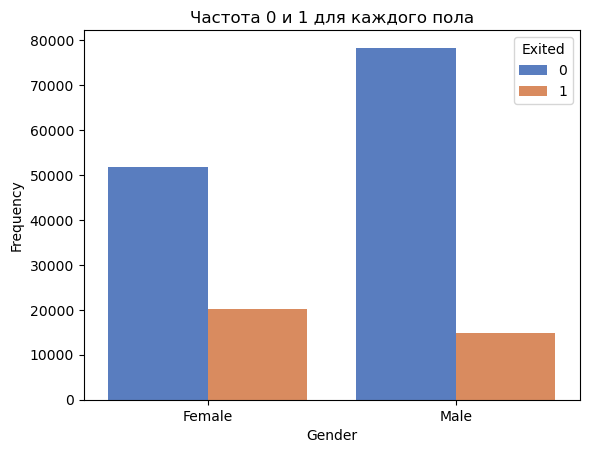

In [15]:
counts = df.groupby(['Gender', 'Exited']).size().reset_index(name='Frequency')
sns.barplot(x='Gender', y='Frequency', hue='Exited', data=counts, palette='muted')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Частота 0 и 1 для каждого пола')
plt.show()

Женщины более склонны к закрытию счетов, чем мужчины.

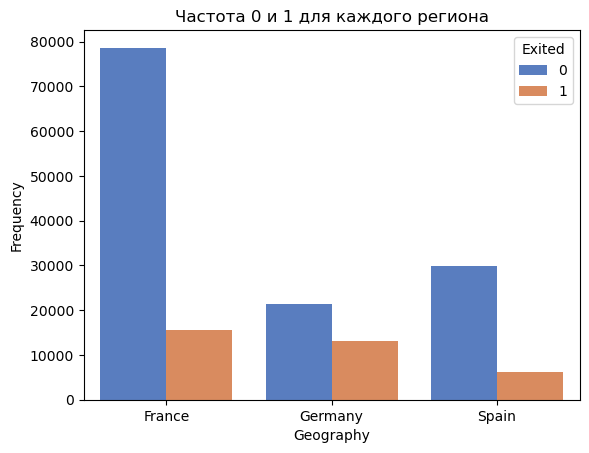

In [16]:
counts = df.groupby(['Geography', 'Exited']).size().reset_index(name='Frequency')
sns.barplot(x='Geography', y='Frequency', hue='Exited', data=counts, palette='muted')
plt.xlabel('Geography')
plt.ylabel('Frequency')
plt.title('Частота 0 и 1 для каждого региона')
plt.show()

Германия (Germany): Здесь наблюдается самая высокая доля оттока. Столбец Exited=1 (оранжевый) почти равен столбцу Exited=0 (синий) — это значит, что уходит чуть ли не половина клиентов (визуально около 30-40%). Это критическая аномалия по сравнению с другими странами.

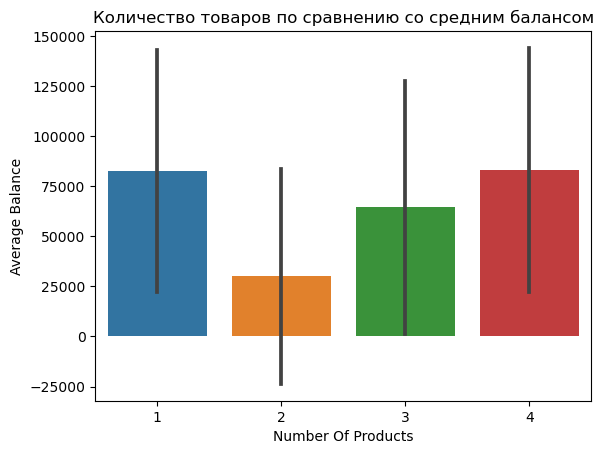

In [17]:
sns.barplot(x=df.NumOfProducts, y=df.Balance, errorbar='sd')
plt.xlabel('Number Of Products')
plt.ylabel('Average Balance')
plt.title('Количество товаров по сравнению со средним балансом')
plt.show()

1 продукт = Высокий баланс: Клиенты с одним продуктом имеют самый высокий средний баланс (~80k+).

2 продукта = Низкий баланс: Резкое падение среднего баланса до ~30k. Это может означать, что второй продукт — это кредитная карта или другой инструмент, который не подразумевает хранения больших сумм, или же это массовый сегмент клиентов с нулевыми балансами (как мы видели ранее).

3-4 продукта = Рост баланса, но огромный разброс: У клиентов с 3-4 продуктами средний баланс снова растет, но черная линия (стандартное отклонение sd) просто огромна. Это говорит о том, что таких клиентов очень мало (выборка мала), и среди них есть как очень богатые VIP-клиенты, так и те, у кого баланс около нуля. Группа нестабильна

In [18]:
df.groupby("Exited").agg({"EstimatedSalary": "mean"})

,EstimatedSalary
Exited,
0,112084.293725
1,114402.496656


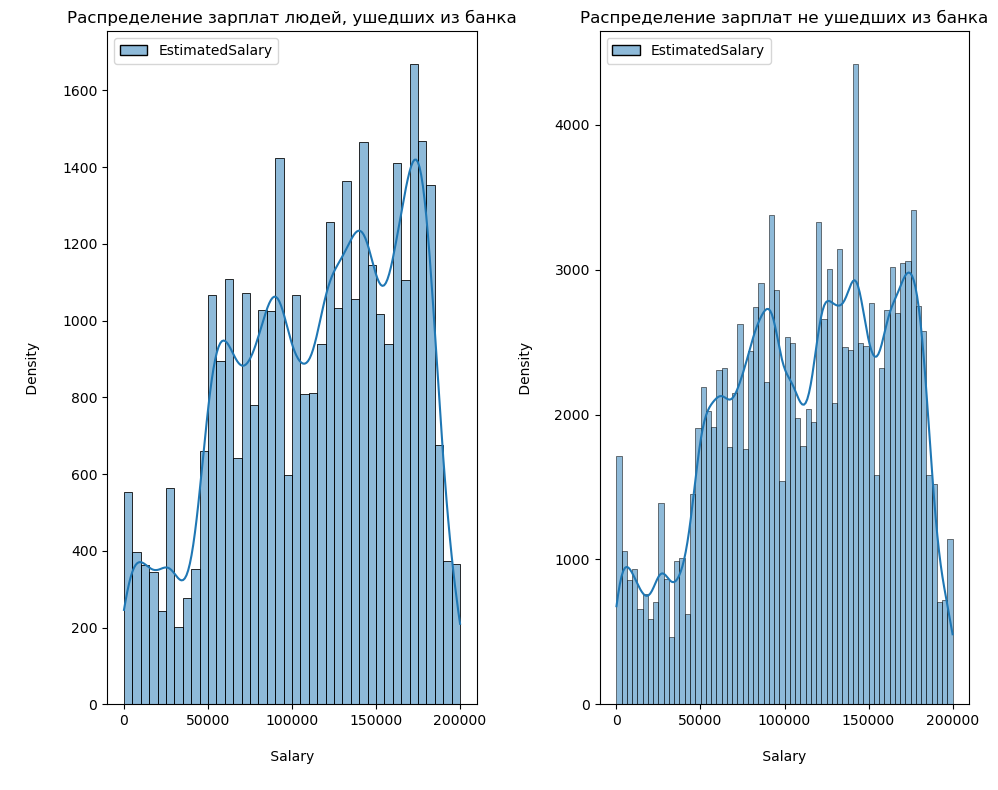

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
sns.histplot(df.loc[df.Exited == 1][["EstimatedSalary"]],kde=True,color="grey", ax=axes[0])
axes[0].set_title('Распределение зарплат людей, ушедших из банка')
axes[0].set_xlabel('\n Salary \n')
axes[0].set_ylabel('\n Density \n')

sns.histplot(df.loc[df.Exited == 0][["EstimatedSalary"]],kde=True,color="grey", ax=axes[1])
axes[1].set_title('Распределение зарплат не ушедших из банка')
axes[1].set_xlabel('\n Salary \n')
axes[1].set_ylabel('\n Density \n')
plt.tight_layout()
plt.show()

Оба графика (Density vs Salary) выглядят практически одинаково. Они оба "шумные", с пиками и падениями в одних и тех же местах, и равномерно размазаны по диапазону от 0 до 200 000. Размер оценочной зарплаты никак не помогает предсказать отток. Богатые и бедные клиенты уходят с одинаковой вероятностью.​

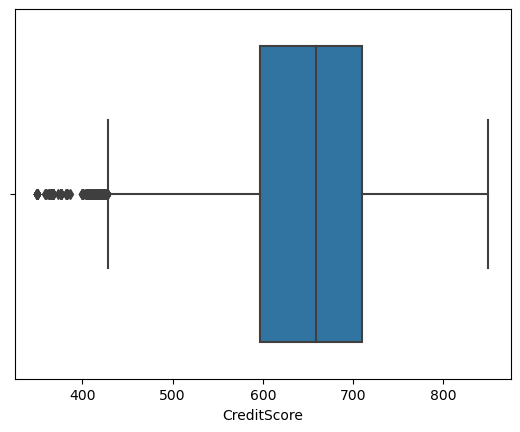

In [22]:
fig = sns.boxplot(df, x='CreditScore')
plt.show()

In [23]:
# в CreditScore есть выбросы
q1 = df['CreditScore'].quantile(.25)
q3 = df['CreditScore'].quantile(.75)
iqr = q3-q1

lower = q1-(iqr*1.5)
upper = q3+(iqr*1.5)
lower, upper

(427.5, 879.5)

In [24]:
print('Количество выбросов в столбце CreditScore:',len(df.loc[(df['CreditScore']>upper)|(df['CreditScore']<lower)]))

Количество выбросов в столбце CreditScore: 253


In [25]:
correlation_matrix = df.corr()

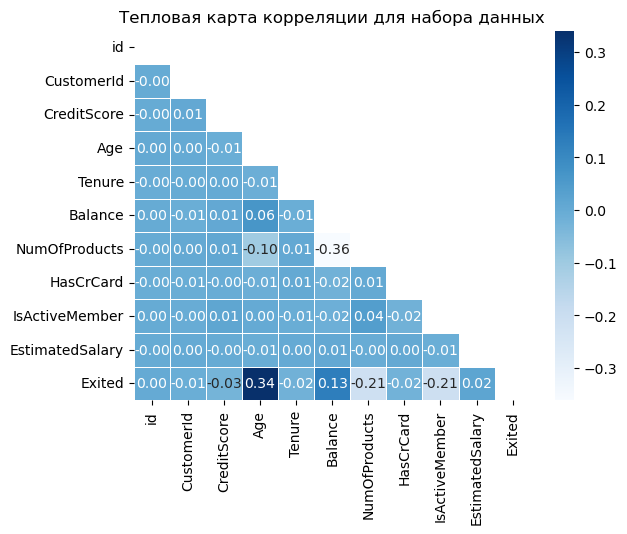

In [26]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=.5, mask=mask)
plt.title('Тепловая карта корреляции для набора данных')
plt.show()

1. Самая сильная связь — Возраст и Отток (Age vs Exited)
Коэффициент 0.34 (самый темный синий квадрат в строке Exited). Это единственная действительно значимая позитивная корреляция с целевой переменной.

Вывод: Чем старше клиент, тем выше вероятность, что он уйдет. Это самый мощный предиктор для модели (как мы и видели на первом графике).

2. Отрицательная корреляция — Активность и Количество продуктов
IsActiveMember vs Exited (-0.21): Заметная отрицательная связь. Активные клиенты уходят реже. Это второй по важности признак.

NumOfProducts vs Exited (-0.21): Здесь тоже отрицательная связь, но с нюансом. В целом, чем больше продуктов, тем ниже риск ухода (клиент глубже "увяз" в экосистеме банка). Однако, вспоминаем график выше: при 3-4 продуктах риск снова рос, но линейная корреляция этого не ловит, она усредняет тренд.

3. Интересная внутренняя связь: Баланс и Продукты
Самая сильная отрицательная корреляция во всей матрице: Balance vs NumOfProducts (-0.36).

Чем больше у клиента продуктов, тем меньше у него денег на счете (в среднем).

Почему так? Это подтверждает нашу гипотезу: клиенты с 1 продуктом держат там основные сбережения (высокий баланс). Клиенты с 2+ продуктами часто имеют кредитки или вспомогательные счета с малыми остатками, что тянет средний баланс вниз.

# Preprocessing for model

In [29]:
X,y = df.drop(['Surname','id','CustomerId','Exited'], axis=1), df['Exited']

In [30]:
X['Gender'] = X['Gender'].map({'Female': 1, 'Male': 0})
X = pd.get_dummies(X, columns=['Geography'])
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,668,0,33.0,3,0.00,2,1.0,0.0,181449.97,1,0,0
1,627,0,33.0,1,0.00,2,1.0,1.0,49503.50,1,0,0
2,678,0,40.0,10,0.00,2,1.0,0.0,184866.69,1,0,0
3,581,0,34.0,2,148882.54,1,1.0,1.0,84560.88,1,0,0
4,716,0,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,1


In [31]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=.2,random_state=42, stratify=y)

In [32]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report

results = {}

def evaluate_model(model, X_test, y_test, model_name):
    """
    Функция для расчета метрик и вывода отчета
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    print(f"--- {model_name} ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("\nReport:")
    print(classification_report(y_test, y_pred))

    return {'Accuracy': acc, 'ROC-AUC': roc, 'F1-Score': f1}

In [39]:
from sklearn.model_selection import GridSearchCV

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}

lr_grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=3, scoring='roc_auc', n_jobs=-1)
lr_grid.fit(X_train, y_train)

best_lr = lr_grid.best_estimator_
print(f"Лучшие параметры LogReg: {lr_grid.best_params_}")

results['LogisticRegression'] = evaluate_model(best_lr, X_test, y_test, 'LogisticRegression')

Лучшие параметры LogReg: {'C': 0.01, 'solver': 'liblinear'}
--- LogisticRegression ---
Accuracy:  0.8334
ROC-AUC:   0.8145
F1-Score:  0.4914

Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     26023
           1       0.69      0.38      0.49      6984

    accuracy                           0.83     33007
   macro avg       0.77      0.67      0.70     33007
weighted avg       0.82      0.83      0.81     33007



In [40]:
knn_params = {
    'n_neighbors': [5, 15, 25],
    'weights': ['uniform', 'distance']
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, scoring='roc_auc', n_jobs=-1)
knn_grid.fit(X_train, y_train)

best_knn = knn_grid.best_estimator_
print(f"Лучшие параметры KNN: {knn_grid.best_params_}")

results['KNN'] = evaluate_model(best_knn, X_test, y_test, 'KNN')

Лучшие параметры KNN: {'n_neighbors': 25, 'weights': 'uniform'}
--- KNN ---
Accuracy:  0.8562
ROC-AUC:   0.8686
F1-Score:  0.5960

Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     26023
           1       0.73      0.50      0.60      6984

    accuracy                           0.86     33007
   macro avg       0.81      0.73      0.75     33007
weighted avg       0.85      0.86      0.85     33007



In [41]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [1, 4]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
print(f"Лучшие параметры Random Forest: {rf_grid.best_params_}")

results['RandomForest'] = evaluate_model(best_rf, X_test, y_test, 'RandomForest')

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Лучшие параметры Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 200}
--- RandomForest ---
Accuracy:  0.8628
ROC-AUC:   0.8876
F1-Score:  0.6093

Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     26023
           1       0.77      0.51      0.61      6984

    accuracy                           0.86     33007
   macro avg       0.82      0.73      0.76     33007
weighted avg       0.85      0.86      0.85     33007



                    Accuracy   ROC-AUC  F1-Score
RandomForest        0.862787  0.887569  0.609333
KNN                 0.856152  0.868576  0.595984
LogisticRegression  0.833369  0.814533  0.491400


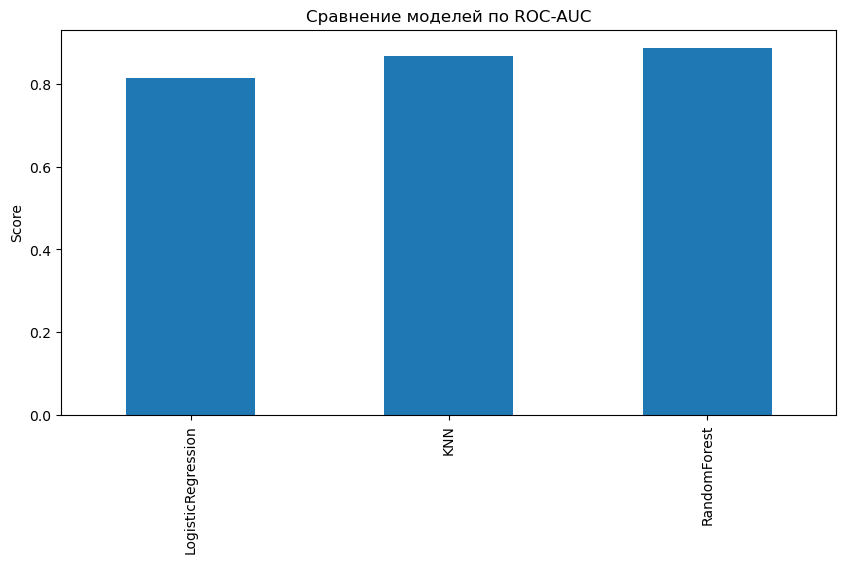

In [42]:
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='ROC-AUC', ascending=False))

results_df['ROC-AUC'].plot(kind='bar', figsize=(10, 5), title='Сравнение моделей по ROC-AUC')
plt.ylabel('Score')
plt.show()

In [43]:
print("--- Обучение Random Forest с учетом дисбаланса (class_weight='balanced') ---")

balanced_rf = RandomForestClassifier(
    **rf_grid.best_params_,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

balanced_rf.fit(X_train, y_train)

results['RF_Balanced'] = evaluate_model(balanced_rf, X_test, y_test, 'RF_Balanced')

print("\nСравнение Recall (полноты) для класса 1 (Отток):")
from sklearn.metrics import recall_score
recall_old = recall_score(y_test, best_rf.predict(X_test))
recall_new = recall_score(y_test, balanced_rf.predict(X_test))

print(f"Обычный RF Recall:      {recall_old:.4f}")
print(f"Сбалансированный RF Recall: {recall_new:.4f}")


--- Обучение Random Forest с учетом дисбаланса (class_weight='balanced') ---
--- RF_Balanced ---
Accuracy:  0.8210
ROC-AUC:   0.8867
F1-Score:  0.6482

Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     26023
           1       0.55      0.78      0.65      6984

    accuracy                           0.82     33007
   macro avg       0.74      0.81      0.76     33007
weighted avg       0.85      0.82      0.83     33007


Сравнение Recall (полноты) для класса 1 (Отток):
Обычный RF Recall:      0.5057
Сбалансированный RF Recall: 0.7794


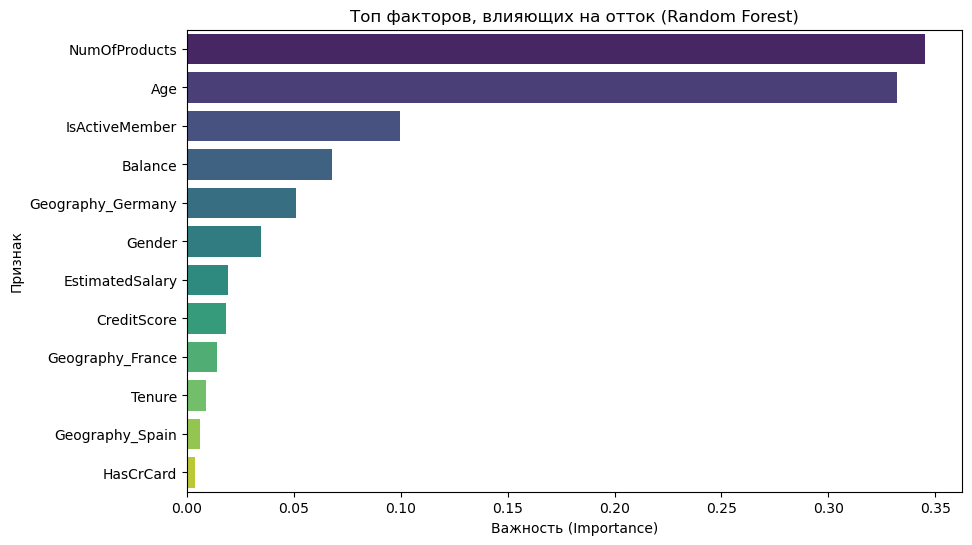

Топ-5 самых важных признаков:
              Feature  Importance
5       NumOfProducts    0.345295
2                 Age    0.332234
7      IsActiveMember    0.099427
4             Balance    0.067902
10  Geography_Germany    0.050956


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = balanced_rf.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Топ факторов, влияющих на отток (Random Forest)')
plt.xlabel('Важность (Importance)')
plt.ylabel('Признак')
plt.show()

print("Топ-5 самых важных признаков:")
print(feature_importances.head(5))


Для внедрения в бизнес-процессы банка рекомендуется использовать **сбалансированный Random Forest**. Эта модель позволит менеджерам фокусироваться на действительно проблемных клиентах, предотвращая до **78%** потенциального оттока, что значительно эффективнее, чем "стрельба вслепую" или использование простой логистической регрессии.